In [49]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from abc import ABC, abstractmethod

In [50]:
seed = 5
np.random.seed(seed)

Declaração de funções custo

In [51]:
def sigmoid(y: NDArray):
    return 1 / (1 + np.exp(-y))

def softmax(Y: NDArray):
    Y_shifted = Y - np.max(Y, axis=1, keepdims=True)

    exp = np.exp(Y_shifted)
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy(Y: NDArray, Y_predict: NDArray):
    return -np.mean(Y * np.log(Y_predict + 1e-12))

def MSE(y: NDArray, y_predict: NDArray):
    squared_errors = (y - y_predict)**2
    return np.mean(squared_errors)

def RMSE(y: NDArray, y_predict: NDArray):
    return np.sqrt(MSE(y, y_predict))

Declaração dos escaladores MinMax e ZScore

In [52]:
class Scaler(ABC):
    @abstractmethod
    def normalize(self, X: NDArray, update_params: bool = False) -> NDArray:
        pass

    @abstractmethod
    def denormalize(self, X: NDArray) -> NDArray:
        pass

class ZScore(Scaler):
    def __init__(self):
        self.mean: NDArray = None
        self.std: NDArray = None
        pass

    def normalize(self, X: NDArray, update_params: bool = False):
        mean = np.mean(X, axis=0) if self.mean is None or update_params else self.mean
        std = np.std(X, axis=0) if self.std is None or update_params else self.std

        self.mean = mean
        self.std = std

        return (X - mean) / std

    def denormalize(self, X: NDArray):
        return X * self.std + self.mean

class MinMax(Scaler):
    def __init__(self):
        self.min = None
        self.max = None
        pass

    def normalize(self, X: NDArray, update_params: bool = False):
        min = np.min(X, axis=0) if self.min is None or update_params else self.min
        max = np.max(X, axis=0) if self.max is None or update_params else self.max

        self.min = min
        self.max = max

        return (X - min) / (max - min)

    def denormalize(self, X: NDArray):
        return X * (self.max - self.min) + self.min


Declaração dos modelos usados na lista
- Regressão Logística por Gradiente Descendente
- Regressão SoftMax por Gradiente Descendente
- Análise do Discriminante Gaussiano
- Naive Bayes Gaussiano

In [53]:
class Model(ABC):
    has_metrics = False

    @abstractmethod
    def train(self, X: NDArray, y: NDArray):
        pass

    @abstractmethod
    def predict(self, X: NDArray) -> tuple[NDArray, NDArray]:
        pass

class RLGD(Model):
    '''Regressão Logistica Gradiente Descendente'''

    has_metrics = True

    def __init__(self, epochs = 10000, learning_rate = 0.1):
        self.w: NDArray = None
        self.in_scaler = ZScore()
        self.metrics: list[float] = []
        self.epochs = epochs
        self.learning_rate = learning_rate

    def train(self, X: NDArray, y: NDArray):
        X = self._preprocess_input(X, True)
        n, m = X.shape

        w = np.random.randn(m, 1) * 0.001

        self.metrics = []
        for _ in range(self.epochs):
            y_predict = sigmoid(X @ w)

            errors = y - y_predict
            gradient = (X.T @ errors) / n
            w = w + self.learning_rate * gradient

            self.metrics.append(cross_entropy(y, y_predict))

        self.w = w

    def predict(self, X: NDArray):
        X = self._preprocess_input(X, False)
        y_predict = sigmoid(X @ self.w)

        return y_predict, y_predict

    def _preprocess_input(self, X: NDArray, update_params: bool = False):
        n, m = X.shape
        X_normalized = self.in_scaler.normalize(X, update_params)
        return np.c_[np.ones(n), X_normalized]


class RSMGD(Model):
    '''Regressão Soft Max Gradiente Descendente'''

    has_metrics = True

    def __init__(self, n_classes: int, epochs = 10000, learning_rate = 0.1):
        self.n_classes = n_classes
        self.W: NDArray = None
        self.in_scaler = ZScore()
        self.metrics: list[float] = []
        self.epochs = epochs
        self.learning_rate = learning_rate

    def train(self, X: NDArray, y: NDArray):
        X = self._preprocess_input(X, True)
        Y = self._preprocess_output(y)
        n, m = X.shape

        W = np.random.randn(m, self.n_classes) * np.sqrt(1/m)

        self.metrics = []
        for _ in range(self.epochs):
            Y_predict = softmax(X @ W)

            errors = Y - Y_predict
            gradient = (X.T @ errors) / n
            W = W + self.learning_rate * gradient

            self.metrics.append(cross_entropy(Y, Y_predict))

        self.W = W

    def predict(self, X: NDArray):
        X = self._preprocess_input(X, False)
        y_predict = softmax(X @ self.W)

        return np.argmax(y_predict, axis=1).reshape(-1, 1), y_predict

    def _preprocess_input(self, X: NDArray, update_params: bool = False):
        n, m = X.shape
        X_normalized = self.in_scaler.normalize(X, update_params)
        return np.c_[np.ones(n), X_normalized]

    def _preprocess_output(self, y: NDArray):
        n, m = y.shape
        Y = np.zeros((n, self.n_classes))
        for i in range(n):
            Y[i][int(y[i, 0])] = 1

        return Y

class ADG_Params():
    '''Armazena os parâemtros de probabilidade de cada classe para o ADG'''

    def __init__(self, n_classes, mean, det, inv):
        self.n_classes = n_classes
        self.mean = mean
        self.det = det
        self.inv = inv

    def get_probability(self, X: NDArray):
        return (
            np.log(1 / self.n_classes)
            - 0.5 * np.log(self.det)
            - 0.5 * (X - self.mean) @ self.inv @ (X - self.mean).T
        ).diagonal()

class ADG(Model):
    '''Análise do Discriminante Gaussiano'''

    def __init__(self, n_classes: int):
        self.n_classes = n_classes
        self.params: list[ADG_Params] = [None] * self.n_classes

    def train(self, X: NDArray, y: NDArray):
        X = self._preprocess_input(X)
        for i in range(self.n_classes):
            class_collumns = np.nonzero(y == i)[0]
            X_class = X[class_collumns]

            mean = X_class.mean(axis=0)
            covariant = np.cov(X_class, rowvar=False)
            inv = np.linalg.inv(covariant)
            det = np.linalg.det(covariant)

            self.params[i] = ADG_Params(self.n_classes, mean, det, inv)

    def predict(self, X: NDArray):
        X = self._preprocess_input(X)
        Y_predict = np.array([
            params.get_probability(X)
            for params in self.params
        ]).T

        return np.argmax(Y_predict, axis=1).reshape(-1, 1), Y_predict

    def _preprocess_input(self, X: NDArray):
        n, m = X.shape
        return X

class NBG_Params():
    '''Armazena os parâemtros de probabilidade de cada classe para o NBG'''

    def __init__(self, n_classes: int, mean: NDArray, covariant: NDArray):
        self.n_classes = n_classes
        self.mean = mean
        self.covariant = covariant

    def get_probability(self, X: NDArray):
        return (
            np.log(1/self.n_classes)
            - 0.5 * np.sum(np.log(2 * np.pi * self.covariant + 1e-9), axis=1)
            - 0.5 * np.sum(((X - self.mean)**2)/(self.covariant + 1e-9), axis=1)
        )


class NBG(Model):
    '''Naive Bayes Gaussiano'''

    def __init__(self, n_classes: int):
        self.n_classes = n_classes
        self.in_scaler = MinMax()
        self.params: list[NBG_Params] = [None] * self.n_classes

    def train(self, X: NDArray, y: NDArray):
        X = self._preprocess_input(X)
        for i in range(self.n_classes):
            class_collumns = np.nonzero(y == i)[0]
            X_class = X[class_collumns]

            mean = X_class.mean(axis=0)
            covariant = X_class.var(axis=0, ddof=1, keepdims=True)

            self.params[i] = NBG_Params(self.n_classes, mean, covariant)

    def predict(self, X: NDArray):
        X = self._preprocess_input(X)
        Y_predict = np.array([
            params.get_probability(X)
            for params in self.params
        ]).T

        return np.argmax(Y_predict, axis=1).reshape(-1, 1), Y_predict

    def _preprocess_input(self, X: NDArray):
        n, m = X.shape
        return np.c_[np.ones(n), X]


Classe para treinar um modelo usando validação cruzada (K-Folds) e calcular as métricas

In [54]:
class KFoldTrainer:
    def __init__(self, model: Model, k: int, n_classes: int, X: NDArray, y: NDArray):
        self.model = model
        self.k = k
        self.n_classes = n_classes
        self.X = X
        self.y = y
        self.accuracies_global = np.zeros((k))
        self.accuracies_per_class = np.zeros((k, n_classes))

    def train(self):
        for i, dataset in enumerate(self._genereate_dataset_k_folds()):
            X_train, y_train, X_validation, y_validation = dataset
            self.model.train(X_train, y_train)

            y_predict, _ = self.model.predict(X_validation)
            n = y_predict.shape[0]
            n_per_class = np.zeros(self.n_classes)
            for j in range(n):
                n_per_class[int(y_validation[j][0])] += 1

            true_positives_global = 0
            true_positives_per_class = np.zeros(self.n_classes)
            for j in range(n):
                is_true_positive = abs(y_validation[j] - y_predict[j]) < 0.5

                if is_true_positive:
                    true_positives_global += 1
                    true_positives_per_class[int(y_validation[j, 0])] += 1

            self.accuracies_global[i] = true_positives_global / n
            self.accuracies_per_class[i] = true_positives_per_class / n_per_class

        self.model.train(self.X, self.y)

    def _genereate_dataset_k_folds(self):
        validation_percent = 1 / self.k

        n, _ = self.X.shape
        validation_size = ceil(n * validation_percent)
        for i in range(self.k):
            validation_index_start = i * validation_size
            validation_index_final = (i + 1) * validation_size if i < self.k - 1 else n

            X_validation = self.X[validation_index_start:validation_index_final]
            y_validation = self.y[validation_index_start:validation_index_final]
            X_train = np.concatenate([self.X[:validation_index_start], self.X[validation_index_final:]])
            y_train = np.concatenate([self.y[:validation_index_start], self.y[validation_index_final:]])

            yield X_train, y_train, X_validation, y_validation


Funções auxiliares

In [55]:
def genereate_dataset(filename: str, training_percent: float) -> tuple[NDArray, NDArray, NDArray, NDArray]:
    dataset = np.genfromtxt(filename, delimiter=',')
    np.random.shuffle(dataset)

    n, _ = dataset.shape
    X = dataset[:, :-1]
    y = dataset[:, -1].astype(float).reshape((-1, 1))

    training_size = ceil(n * training_percent)
    return X[:training_size], y[:training_size], X[training_size:], y[training_size:]

def plot_metrics(metrics: NDArray, title: str):
    plt.plot(metrics)
    plt.xlabel('Épocas')
    plt.ylabel('Cross Entropia')
    plt.title(f'Função Custo {title}')
    plt.show()


# Questão 01

Lendo o dataset 'breastcancer.csv' separando 20% para teste

In [56]:
X_train, y_train, X_test, y_test = genereate_dataset('breastcancer.csv', 0.8)


## Items a,b

Treinando os modelos Regressão Logística, Análise do Discriminante Gaussiano e Naive Bayes Gaussiano com o dataset 01 usando validação cruzada com 10 folds.
Reportando a média e o desvio padrão da acurácia global e por classe

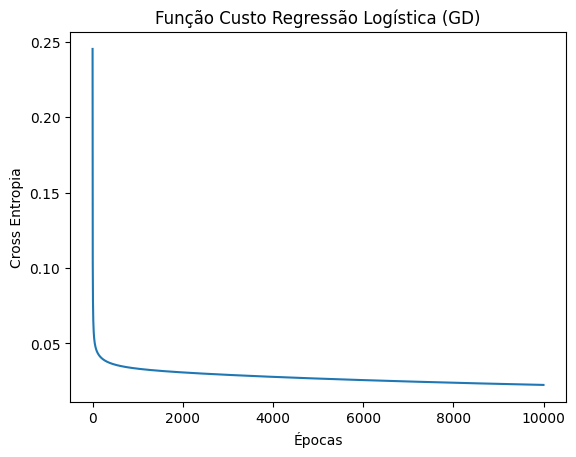

Treinamento usando Regressão Logística (GD) com 10 folds
Acurácia média global: 0.977639751552795
Desvio padrão da acurácia global: 0.020869934927219173
Acurácia média por classe:
· Classe 0: 0.9898776418242491
· Classe 1: 0.9595676691729323

Desvio padrão da acurácia por classe:
· Classe 0: 0.015472823466098013
· Classe 1: 0.0576185246830901
------------------------------

Treinamento usando Análise do Discriminante Gaussiano com 10 folds
Acurácia média global: 0.9537267080745341
Desvio padrão da acurácia global: 0.02330020556758097
Acurácia média por classe:
· Classe 0: 0.9558306410089188
· Classe 1: 0.9525899307091258

Desvio padrão da acurácia por classe:
· Classe 0: 0.0327758262212348
· Classe 1: 0.053882033164131815
------------------------------

Treinamento usando Naive Bayes Gaussiano com 10 folds
Acurácia média global: 0.945031055900621
Desvio padrão da acurácia global: 0.031397192987266405
Acurácia média por classe:
· Classe 0: 0.9644775058707206
· Classe 1: 0.91713069438301

In [57]:
k = 10
n_classes = 2
models = [
    ('Regressão Logística (GD)', RLGD()),
    ('Análise do Discriminante Gaussiano', ADG(n_classes)),
    ('Naive Bayes Gaussiano', NBG(n_classes)),
]

for name, model in models:
    ktrainer = KFoldTrainer(model, k, n_classes, X_train, y_train)
    ktrainer.train()

    if model.has_metrics:
        plot_metrics(model.metrics, name)

    print(f"Treinamento usando {name} com {k} folds")
    print("Acurácia média global:", np.mean(ktrainer.accuracies_global))
    print("Desvio padrão da acurácia global:", np.std(ktrainer.accuracies_global))
    print("Acurácia média por classe:")
    for i, mean in enumerate(np.mean(ktrainer.accuracies_per_class, axis=0)):
        print(f'· Classe {i}: {mean}')

    print("\nDesvio padrão da acurácia por classe:")
    for i, std in enumerate(np.std(ktrainer.accuracies_per_class, axis=0)):
        print(f'· Classe {i}: {std}')

    print('-' * 30)
    print()


In [58]:
X_train_2, y_train_2, X_test_2, y_test_2 = genereate_dataset('vehicle.csv', 0.8)

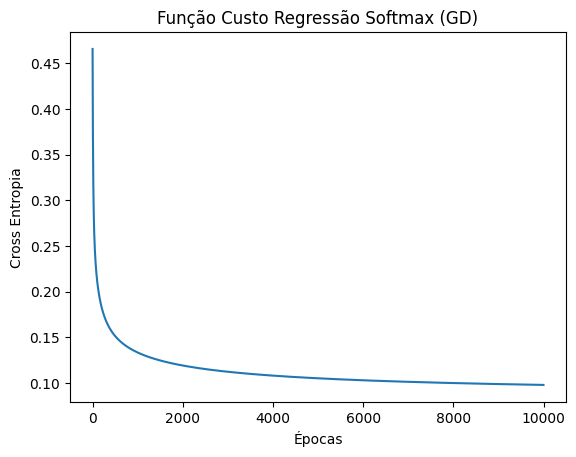

Treinamento usando Regressão Softmax (GD) com 10 folds
Acurácia média global: 0.7884841628959276
Desvio padrão da acurácia global: 0.05480163427474271
Acurácia média por classe:
· Classe 0: 0.9392265234765237
· Classe 1: 0.6057945928340664
· Classe 2: 0.6694479458450047
· Classe 3: 0.9625201465201465

Desvio padrão da acurácia por classe:
· Classe 0: 0.05617780042948502
· Classe 1: 0.1484005307635421
· Classe 2: 0.09529070441939613
· Classe 3: 0.05591654170141827
------------------------------

Treinamento usando Análise do Discriminante Gaussiano com 10 folds
Acurácia média global: 0.8448416289592761
Desvio padrão da acurácia global: 0.054479224604195076
Acurácia média por classe:
· Classe 0: 0.9690219780219781
· Classe 1: 0.7511748120300752
· Classe 2: 0.6975046685340802
· Classe 3: 0.9639029304029304

Desvio padrão da acurácia por classe:
· Classe 0: 0.032595801783755124
· Classe 1: 0.1196576776526919
· Classe 2: 0.13239396623082753
· Classe 3: 0.04181123047798091
------------------

In [59]:
k = 10
n_classes = 4
models_2 = [
    ('Regressão Softmax (GD)', RSMGD(n_classes)),
    ('Análise do Discriminante Gaussiano', ADG(n_classes)),
    ('Naive Bayes Gaussiano', NBG(n_classes)),
]
for name, model in models_2:
    ktrainer = KFoldTrainer(model, k, n_classes, X_train_2, y_train_2)
    ktrainer.train()

    if model.has_metrics:
        plot_metrics(model.metrics, name)

    print(f"Treinamento usando {name} com {k} folds")
    print("Acurácia média global:", np.mean(ktrainer.accuracies_global))
    print("Desvio padrão da acurácia global:", np.std(ktrainer.accuracies_global))
    print("Acurácia média por classe:")
    for i, mean in enumerate(np.mean(ktrainer.accuracies_per_class, axis=0)):
        print(f'· Classe {i}: {mean}')

    print("\nDesvio padrão da acurácia por classe:")
    for i, std in enumerate(np.std(ktrainer.accuracies_per_class, axis=0)):
        print(f'· Classe {i}: {std}')

    print('-' * 30)
    print()
